In [1]:
from matplotlib import pyplot as plt

In [2]:
import torch
from ppuu.data.dataloader import Dataset, DataStore, Normalizer
from torch.utils.data import DataLoader

# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/traffic-data_offroad/state-action-cost/data_i80_v0/"
# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/vlad/traffic-data_offroad_50_test_train_same/state-action-cost/data_i80_v0/"
# ds_path = "/home/us441/nvidia-collab/vlad/traffic-data-5-small/state-action-cost/data_i80_v0/"
ds_path = "/home/us441/nvidia-collab/vlad/traffic-data-5/state-action-cost/data_i80_v0/"

data_store = DataStore(ds_path)

dataset = Dataset(
    data_store, "val", 20, 30, size=1000, normalize=True, shift=False, random_actions=False, state_diffs=False
)

loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=0,
)

batch = next(iter(loader))

normalizer = Normalizer(data_store.stats)

In [3]:
liter = iter(loader)

In [64]:
batch = next(liter)

for k in batch:
    if torch.is_tensor(batch[k]):
        batch[k] = batch[k].cuda()

In [65]:
from ppuu.costs import PolicyCost
import ppuu.costs.policy_costs_km
from ppuu.costs import PolicyCostContinuous
import imp
imp.reload(ppuu.costs.policy_costs_km)


<module 'ppuu.costs.policy_costs_km' from '/home/us441/work/forked/ppuu/costs/policy_costs_km.py'>

In [66]:
from ppuu.costs import PolicyCost

from ppuu.lightning_modules.policy.mpur import ForwardModelV3
from ppuu.lightning_modules.fm import FM


m_config = FM.Config()
m_config.model.fm_type = "km_no_action"
m_config.model.checkpoint = "/home/us441/nvidia-collab/vlad/results/fm/km_no_action/fm_km_no_action_64/seed=42/checkpoints/last.ckpt"
m_config.training.enable_latent = True
m_config.training.diffs = False
fm = FM(m_config)
fm._setup_normalizer(data_store.stats)
fm.model.device = torch.device('cuda:0')

fm.to(torch.device('cuda:0'))

# cost = PolicyCost(PolicyCost.Config(), fm, data_store.stats)
# cost.estimate_uncertainty_stats(loader)
# predictions = batch.copy()
# predictions['pred_images'] = batch['target_images']
# predictions['pred_states'] = batch['target_states']
# predictions['pred_actions'] = batch['actions']
# predictions['Z'] = 

FM(
  (model): FwdCNNKMNoAction_VAE(
    (encoder): Encoder(
      (f_encoder): Sequential(
        (0): Conv2d(60, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): Dropout2d(p=0.0, inplace=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): Dropout2d(p=0.0, inplace=True)
        (5): LeakyReLU(negative_slope=0.2, inplace=True)
        (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      )
      (s_encoder): Sequential(
        (0): Linear(in_features=100, out_features=256, bias=True)
        (1): Dropout(p=0.0, inplace=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): Dropout(p=0.0, inplace=True)
        (5): LeakyReLU(negative_slope=0.2, inplace=True)
        (6): Linear(in_features=256, out_features=10752, bias=True)
      )
    )
    (decoder): 

In [67]:
batch.keys()

dict_keys(['input_images', 'input_states', 'ego_cars', 'actions', 'target_images', 'target_states', 'target_costs', 'ids', 'car_sizes', 'stats', 's', 't'])

In [68]:
actions = batch['actions'].clone()
actions.requires_grad = True

from ppuu.costs.policy_costs_km import PolicyCostKMTaper

config = PolicyCostKMTaper.Config()
config.u_reg = 0
cost = PolicyCostKMTaper(config, fm.model, normalizer)
cost.traj_landscape = False
predictions = fm.model.unfold(actions, batch)

In [69]:
predictions

{'pred_images': tensor([[[[[5.6377e-03, 1.5489e-04, 1.0172e-03,  ..., 2.2584e-04,
             3.2236e-02, 3.4826e-01],
            [3.7076e-03, 1.1570e-04, 4.7564e-04,  ..., 1.6021e-04,
             2.1310e-02, 2.7172e-01],
            [1.0156e-03, 1.4689e-05, 8.9222e-05,  ..., 5.3851e-06,
             1.2429e-02, 3.4103e-01],
            ...,
            [4.0007e-04, 3.1988e-04, 8.4219e-03,  ..., 6.3126e-03,
             3.9067e-02, 1.0334e-02],
            [4.4424e-04, 4.3031e-04, 8.2152e-03,  ..., 8.8562e-03,
             4.1664e-02, 1.0730e-02],
            [7.5017e-03, 5.0499e-03, 3.0771e-02,  ..., 4.3181e-02,
             9.4349e-02, 4.0454e-02]],
 
           [[8.8763e-01, 8.1542e-01, 3.2842e-01,  ..., 9.0199e-03,
             2.1445e-02, 5.0277e-02],
            [9.6739e-01, 9.0768e-01, 2.9416e-01,  ..., 6.9433e-03,
             7.3328e-03, 4.5223e-02],
            [9.2136e-01, 8.7381e-01, 4.1704e-01,  ..., 6.9104e-03,
             1.5083e-02, 3.3478e-02],
            ...,
   

In [70]:
predictions = fm.model.unfold(actions, batch)

inputs = batch.copy()
inputs['ref_images'] = predictions['pred_images']
inputs['ref_states'] = predictions['pred_states']



In [81]:
from ppuu.modeling.km import predict_states_seq

ITER = 50
LR = 0.1
costs_history_km = []
actions_history_km = []
grad_history_km = []

actions = batch['actions'].clone()
actions.requires_grad = True

optimizer = torch.optim.SGD((actions, ), lr=LR)

for i in range(ITER):
    pred_states = predict_states_seq(batch['input_states'][:, -1], actions, normalizer)
    
    predictions2 = predictions.copy()
    predictions2['pred_actions'] = actions
    predictions2['pred_states'] = pred_states
    
    c = cost.calculate_cost(inputs, predictions2)
    optimizer.zero_grad()
    c['policy_loss'].mean().backward()
    optimizer.step()
    costs_history_km.append(c['policy_loss'].mean().detach())
    actions_history_km.append(actions.clone())
    grad_history_km.append(actions.grad.clone())
    
grad_history_km = torch.stack(grad_history_km).clone().detach().cpu()
actions_history_km = torch.stack(actions_history_km).clone().detach().cpu()
    

In [82]:
actions = batch['actions'].clone()
actions.requires_grad = True

costs_history_fm = []
costs_history_fm_calc_with_km = []

actions_history_fm = []
grad_history_fm = []

optimizer = torch.optim.SGD((actions, ), lr=LR)

for i in range(ITER):
    predictions2 = fm.model.unfold(actions, batch)
    
    c = cost.calculate_cost(batch, predictions2)
    
    pred_states = predict_states_seq(batch['input_states'][:, -1], actions, normalizer)
    predictions3 = predictions.copy()
    predictions3['pred_actions'] = actions
    predictions3['pred_states'] = pred_states
    save_cost = cost.calculate_cost(inputs, predictions3)
    
    optimizer.zero_grad()
    c['policy_loss'].mean().backward()
    optimizer.step()
    costs_history_fm.append(c['policy_loss'].mean().detach())
    costs_history_fm_calc_with_km.append(save_cost['policy_loss'].mean().detach())
    
    actions_history_fm.append(actions.clone())
    grad_history_fm.append(actions.grad.clone())
    
grad_history_fm = torch.stack(grad_history_fm).clone().detach().cpu()
actions_history_fm = torch.stack(actions_history_fm).clone().detach().cpu()

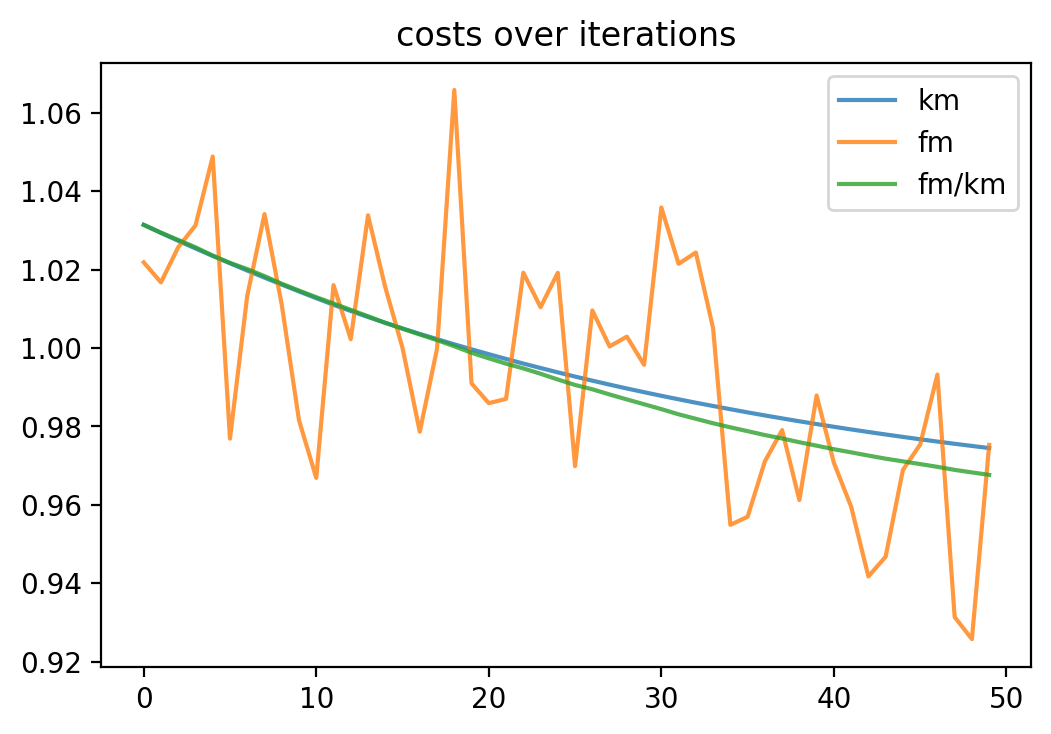

In [84]:
from matplotlib import pyplot as plt
plt.figure(dpi=200)
plt.title('costs over iterations')
plt.plot(costs_history_km, label='km', alpha=0.8)
plt.plot(costs_history_fm, label='fm', alpha=0.8)
plt.plot(costs_history_fm_calc_with_km, label='fm/km', alpha=0.8)
plt.legend()

In [85]:
actions_history_km.shape

torch.Size([50, 1, 30, 2])

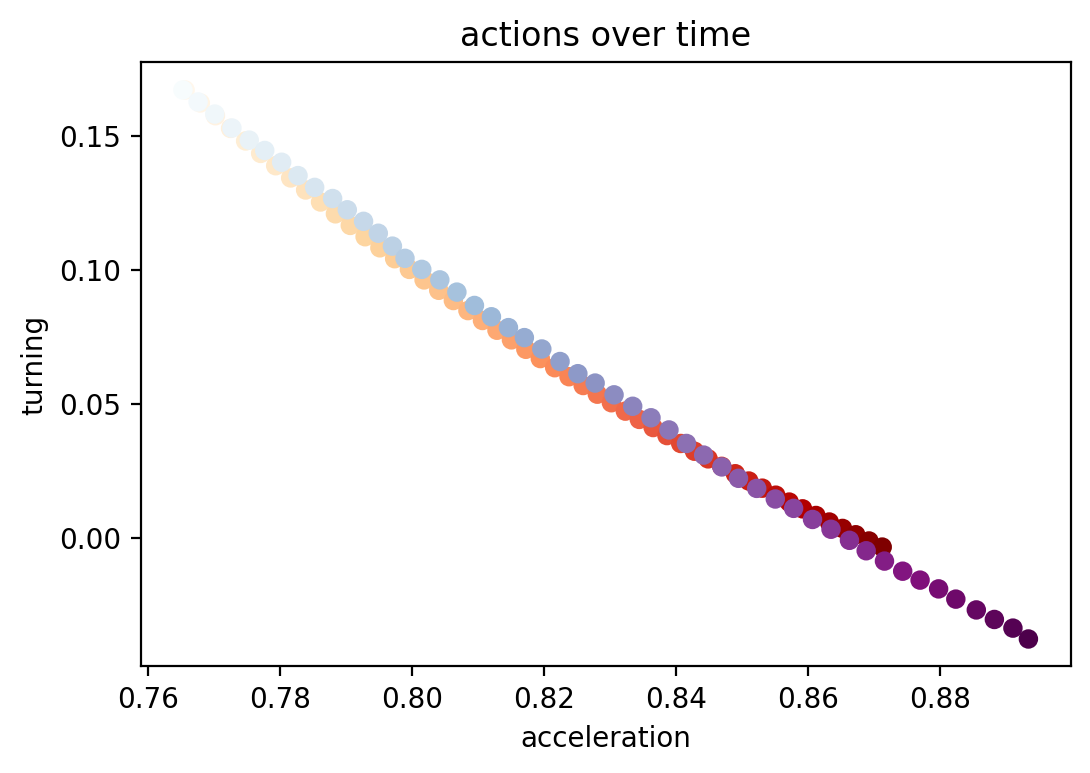

In [86]:
plt.figure(dpi=200)
plt.title('actions over time')
plt.xlabel('acceleration')
plt.ylabel('turning')
plt.scatter(x=actions_history_km[:, 0, 0, 0], y=actions_history_km[:, 0, 0, 1], c=range(ITER), cmap='OrRd')
plt.scatter(x=actions_history_fm[:, 0, 0, 0], y=actions_history_fm[:, 0, 0, 1], c=range(ITER), cmap='BuPu')

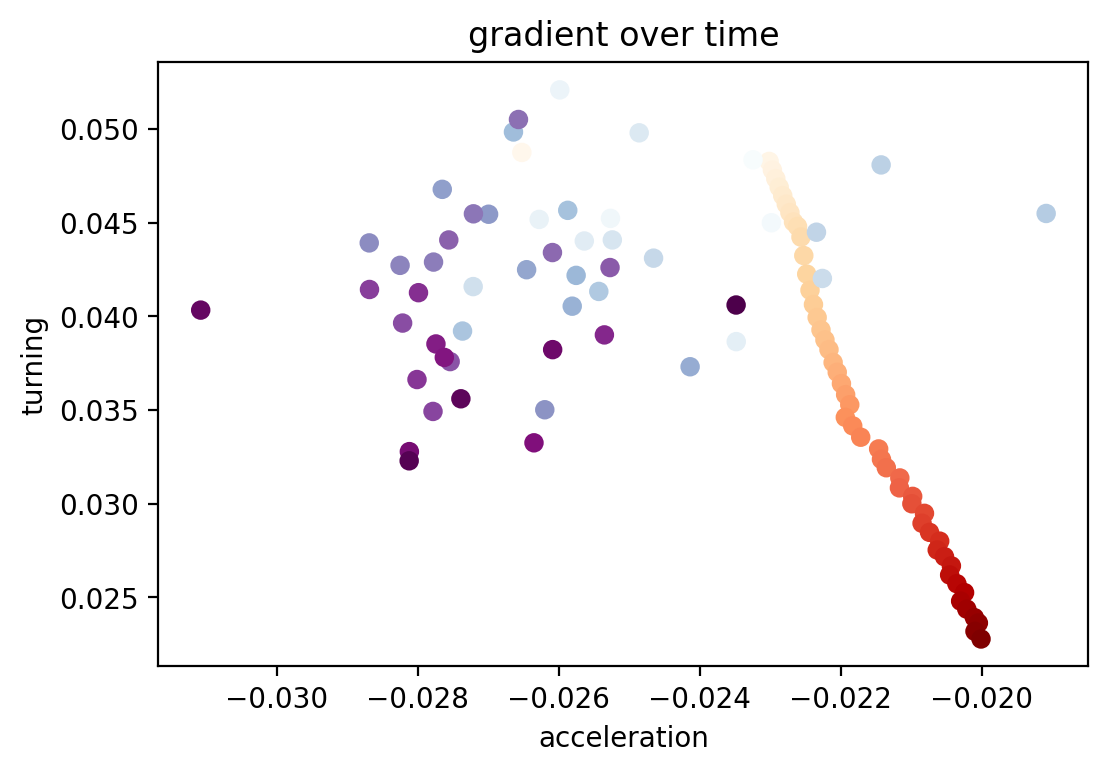

In [87]:
plt.figure(dpi=200)
plt.title('gradient over time')
plt.xlabel('acceleration')
plt.ylabel('turning')
plt.scatter(x=grad_history_km[:, 0, 0, 0], y=grad_history_km[:, 0, 0, 1], c=range(ITER), cmap='OrRd')
plt.scatter(x=grad_history_fm[:, 0, 0, 0], y=grad_history_fm[:, 0, 0, 1], c=range(ITER), cmap='BuPu')

In [88]:
from torchvision import transforms

transform = transforms.ToPILImage()

def get_overlay(cost, inputs, predictions, actions):
    pred_states = predict_states_seq(inputs['input_states'][:, -1], actions, normalizer)
    
    predictions2 = predictions.copy()
    predictions2['pred_actions'] = actions
    predictions2['pred_states'] = pred_states
    
    c = cost.calculate_cost(inputs, predictions2)
    
    big_image = (
        cost.overlay[0].clone()
        .detach()
        .cpu()
        .mul_(255.0)
        .clamp_(0, 255)
        .type(torch.uint8)
        .permute(1, 2, 0, 3)
        .reshape(3, 117, -1)
    )
    big_image = transform(big_image)

    return big_image

overlay = get_overlay(cost, inputs, predictions, actions)
    

In [89]:
actions_history_km.shape

torch.Size([50, 1, 30, 2])

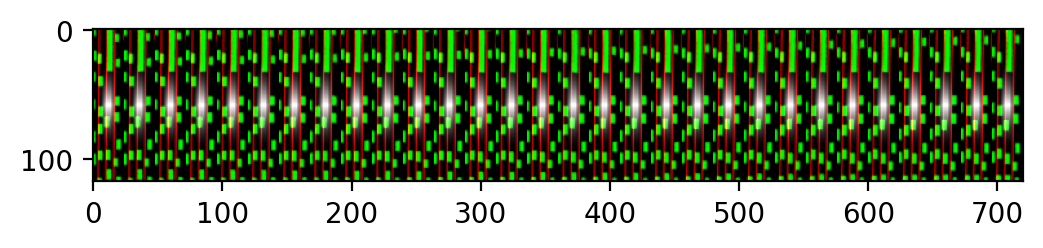

In [90]:
plt.figure(dpi=200)
plt.imshow(get_overlay(cost, inputs, predictions, actions_history_km[0].cuda()))

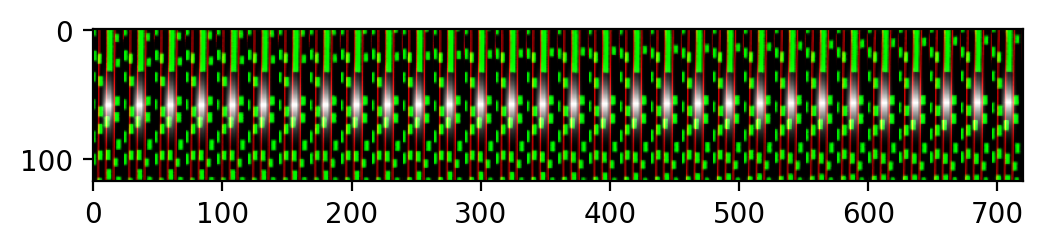

In [91]:
plt.figure(dpi=200)
plt.imshow(get_overlay(cost, inputs, predictions, actions_history_km[-1].cuda()))
# plt.imshow(get_overlay(cost, inputs, predictions, 1 * torch.ones_like(actions_history_km[-1].cuda())))

In [355]:
actions_history_km[0, 0, 0]
actions_history_km[-1, 0, 0]

tensor([3.2979, 3.8592])

In [358]:
inputs['ref_states']

tensor([[[ 1.3621e-01, -1.0285e-03, -3.8749e-02, -3.9165e-01,  1.1892e-01],
         [ 1.4623e-01, -2.9306e-03, -3.0218e-04, -2.4324e-01,  1.3831e-01],
         [ 1.5637e-01, -4.3782e-03,  2.6313e-02, -1.0097e-01,  1.5834e-01],
         [ 1.6664e-01, -5.3800e-03,  4.2073e-02,  3.0669e-02,  1.7873e-01],
         [ 1.7704e-01, -5.9603e-03,  4.9558e-02,  1.8151e-01,  1.9797e-01],
         [ 1.8756e-01, -6.0441e-03,  4.4258e-02,  3.5499e-01,  2.1334e-01],
         [ 1.9817e-01, -5.5447e-03,  2.9172e-02,  4.9484e-01,  2.2175e-01],
         [ 2.0884e-01, -4.5697e-03,  1.6922e-02,  5.7099e-01,  2.2536e-01],
         [ 2.1953e-01, -3.3345e-03,  1.2087e-02,  5.9680e-01,  2.2824e-01],
         [ 2.3023e-01, -2.0097e-03,  1.3761e-02,  5.8817e-01,  2.3141e-01],
         [ 2.4096e-01, -7.1167e-04,  1.3831e-02,  5.8757e-01,  2.3410e-01],
         [ 2.5170e-01,  5.8634e-04,  1.3714e-02,  5.8833e-01,  2.3464e-01],
         [ 2.6245e-01,  1.8873e-03,  1.3854e-02,  5.8759e-01,  2.3404e-01],
         [ 2

In [359]:
from ppuu.modeling.km import predict_states_seq


pred_states_2 = predict_states_seq(batch['input_states'][:, -1], actions2, normalizer)
predictions2 = predictions.copy()
predictions2['pred_actions'] = actions2
predictions2['pred_states'] = pred_states_2

predictions3 = fm.model.unfold(actions2, batch)

c2 = cost.calculate_cost(batch, predictions2)
c3 = cost.calculate_cost(batch, predictions3)
print(c2['policy_loss'])
print(c3['policy_loss'])

tensor([1.1065], device='cuda:0', grad_fn=<AddBackward0>)
tensor([1.1080], device='cuda:0', grad_fn=<AddBackward0>)


In [249]:
cache = {}

In [250]:
from tqdm import tqdm
from collections import namedtuple

Res = namedtuple('Res', ['grad', 'mg', 'actions', 'costs', 'examples', 'intersection'])
def check_grad_magnitude(CostType, curl=True, rotate=True, power=1, o=1, p=4, l=1):
    if CostType.__name__ in cache:
        cost = cache[CostType.__name__]
    else:
        cost = CostType(CostType.Config(), fm.model, normalizer)
        cost.traj_landscape = False
        cost.estimate_uncertainty_stats(loader)
        cache[CostType.__name__] = cost
        
    cost.config.u_reg = 0
    cost.config.lambda_o = o
    cost.config.lambda_p = p
    cost.config.lambda_l = l
    cost.config.curl = curl
    cost.config.rotate = rotate
    cost.config.agg_func_str = "sum"
    cost.config.masks_power_x = power
    cost.config.masks_power_y = power
        
    liter = iter(loader)

    magnitudes = []
    examples = []
    gradients = []
    lactions = []
    costs = []
    mask_intersection = []
    for i in tqdm(range(100)):
        batch = next(liter)
        for k in batch:
            if torch.is_tensor(batch[k]):
                batch[k] = batch[k].cuda()
#         actions = torch.zeros_like(batch['actions'].clone())
        actions = batch['actions'].clone()
        actions.requires_grad = True
        predictions = fm.model.unfold(actions, batch)
        blue_channel = predictions['pred_images'][:, :, :, 2].sum(dim=(-1, -2)).view(-1)
        c = cost.calculate_cost(batch, predictions)
        c['policy_loss'].mean().backward()
        rc = c['policy_loss'].repeat(actions.shape[0] * actions.shape[1])
        magnitudes.append(actions.grad.pow(2))
        gradients.append(actions.grad.view(-1, 2))
        lactions.append(actions.view(-1, 2))
        mask_intersection.append(blue_channel)
        costs.append(rc)
        if actions.grad.pow(2).max() > 1e4:
            examples.append(batch)
    return Res(torch.cat(gradients, dim=0),
               torch.cat(magnitudes, dim=0),
               torch.cat(lactions, dim=0),
               torch.cat(costs, dim=0),
               examples, 
               torch.cat(mask_intersection, dim=0))

In [46]:
vanilla_gd, vanilla_mg, vanilla_a, _, vanilla_ex, _ = check_grad_magnitude(PolicyCost)

  0%|          | 0/100 [00:00<?, ?it/s]

[estimating normal uncertainty ranges: 100.0%]


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


In [51]:
continuous_gd, continuous_mg, continuous_a, _, continuous_ex, _ = check_grad_magnitude(PolicyCostContinuous)

  9%|▉         | 9/100 [00:02<00:20,  4.48it/s]


KeyboardInterrupt: 

In [55]:
km_gd, km_mg, km_a, km_c, km_ex, km_inx = check_grad_magnitude(ppuu.costs.policy_costs_km.PolicyCostKMTaper)

  0%|          | 0/100 [00:00<?, ?it/s]

[estimating normal uncertainty ranges: 100.0%]


RuntimeError: grad can be implicitly created only for scalar outputs

In [449]:
results = []
for o, p, l in [(0, 0, 1), (0, 1, 0), (1, 0, 0)]:
    for curl in [True, False]:
        for rotate in [True, False]:
            for power in [1, 2, 4]:
                res = check_grad_magnitude(ppuu.costs.policy_costs_km.PolicyCostKMTaper, 
                                           curl=curl,
                                           rotate=rotate,
                                           power=power,
                                           o=o,
                                           p=p,
                                           l=l)
                result = dict(
                   curl=curl,
                   rotate=rotate,
                   power=power,
                   o=o,
                   p=p,
                   l=l,
                )
                result['mean'] = res.mg.mean()
                result['std'] = res.mg.std()
                result['mean_acc'] = res.mg[:, :, 0].mean()
                result['std_acc'] = res.mg[:, :, 0].std()
                result['mean_turn'] = res.mg[:, :, 1].mean()
                result['std_turn'] = res.mg[:, :, 1].std()
                results.append(result)

100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


In [454]:
len(results)
import pandas as pd


df = pd.DataFrame(results)
df

,curl,rotate,power,o,p,l,mean,std,mean_acc,std_acc,mean_turn,std_turn
0,True,True,1,0,0,1,325.943726,8.238699e+03,5.578745e+02,1.143945e+04,94.012901,2188.027100
1,True,True,2,0,0,1,4208.462402,1.582822e+05,8.356901e+03,2.237663e+05,60.022945,1467.827393
2,True,True,4,0,0,1,28000.783203,7.783766e+05,5.598946e+04,1.100094e+06,12.108316,365.162445
3,True,False,1,0,0,1,162.693161,3.330198e+03,1.426341e+02,2.775207e+03,182.752213,3805.058594
4,True,False,2,0,0,1,9729.797852,2.118847e+05,1.938007e+04,2.993398e+05,79.525299,1474.966064
5,True,False,4,0,0,1,50604.507812,1.510507e+06,1.012013e+05,2.135011e+06,7.746307,348.759216
6,False,True,1,0,0,1,0.000082,6.369500e-04,2.161079e-07,7.467430e-07,0.000163,0.000893
7,False,True,2,0,0,1,0.000579,4.247941e-03,7.338035e-07,2.581318e-06,0.001157,0.005952
8,False,True,4,0,0,1,0.004147,2.148255e-02,4.313640e-06,2.409743e-05,0.008290,0.029811
9,False,False,1,0,0,1,0.000101,9.640904e-04,2.499718e-07,9.289987e-07,0.000201,0.001356


In [455]:
df.sort_values(by='mean')

,curl,rotate,power,o,p,l,mean,std,mean_acc,std_acc,mean_turn,std_turn
6,False,True,1,0,0,1,0.000082,6.369500e-04,2.161079e-07,7.467430e-07,0.000163,0.000893
18,False,True,1,0,1,0,0.000093,4.119279e-04,1.841611e-07,4.830252e-07,0.000187,0.000567
21,False,False,1,0,1,0,0.000097,4.190726e-04,1.757578e-07,5.687784e-07,0.000193,0.000577
9,False,False,1,0,0,1,0.000101,9.640904e-04,2.499718e-07,9.289987e-07,0.000201,0.001356
22,False,False,2,0,1,0,0.000160,6.674306e-04,4.667803e-07,1.405202e-06,0.000319,0.000917
19,False,True,2,0,1,0,0.000217,1.013644e-03,4.559489e-07,1.370687e-06,0.000434,0.001400
23,False,False,4,0,1,0,0.000261,2.023433e-03,1.894156e-06,9.754882e-06,0.000521,0.002838
20,False,True,4,0,1,0,0.000354,3.408296e-03,1.432832e-06,6.163008e-06,0.000706,0.004794
10,False,False,2,0,0,1,0.000555,5.973303e-03,7.556282e-07,3.124980e-06,0.001109,0.008411
7,False,True,2,0,0,1,0.000579,4.247941e-03,7.338035e-07,2.581318e-06,0.001157,0.005952


Text(0, 0.5, 'gradient magnitude')

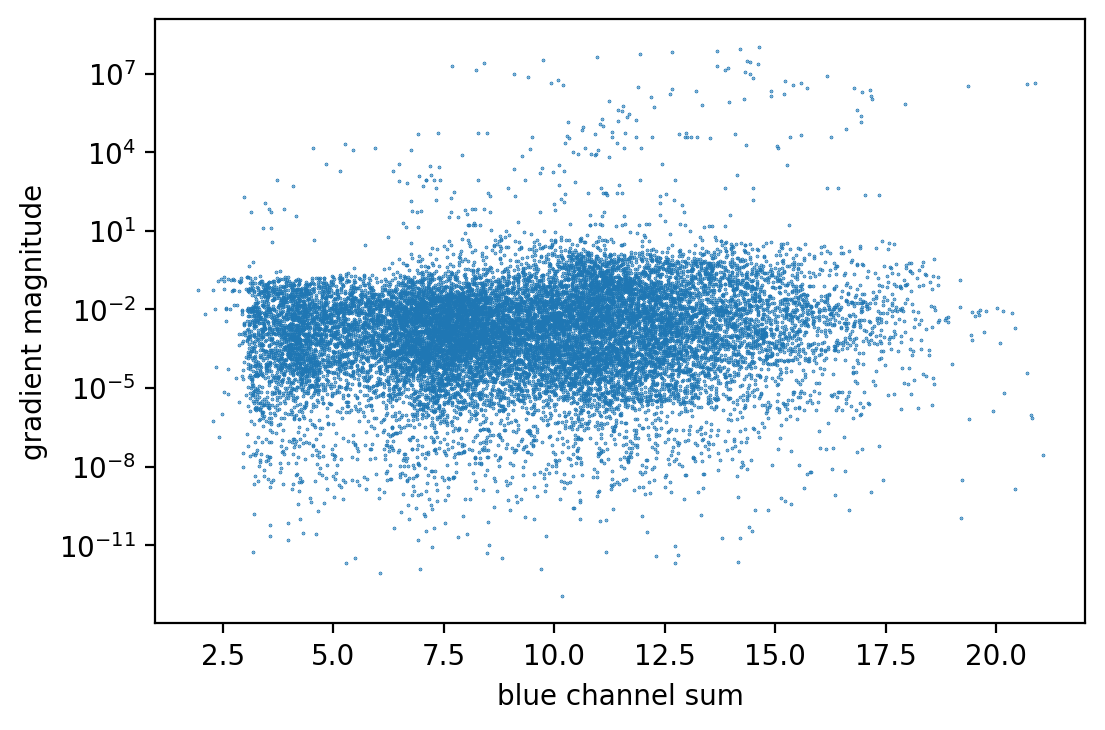

In [434]:
from matplotlib import pyplot as plt
x = km_inx
# x = km_a.max(dim=-1).values
y = km_mg.max(dim=-1).values

plt.figure(dpi=200)
plt.scatter(x.detach().cpu(), y.detach().cpu(), s=0.1)
plt.yscale('log')
plt.xlabel('blue channel sum')
plt.ylabel('gradient magnitude')

In [443]:
y30 = km_mg
y30.shape

torch.Size([600, 30, 2])

In [444]:
ym = y30.mean(dim=0)
ym.shape

torch.Size([30, 2])

Text(0.5, 1.0, 'acc gradient km, power=2')

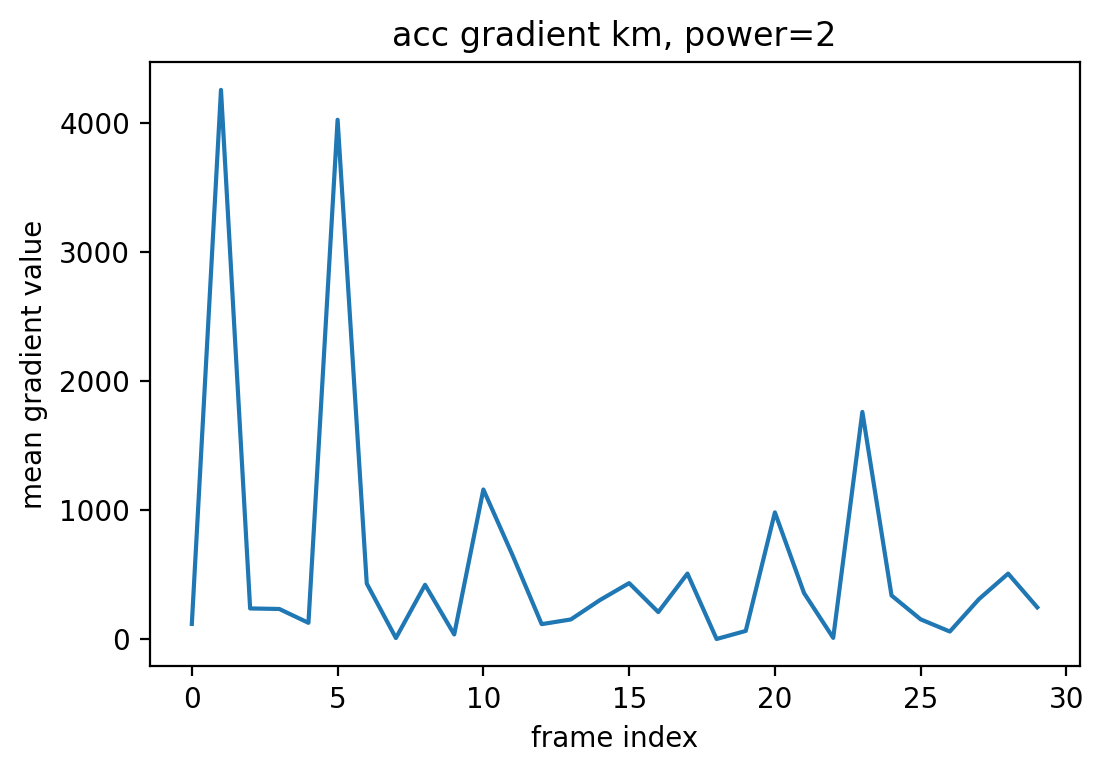

In [445]:
plt.figure(dpi=200)
plt.plot(ym[:, 1].detach().cpu())
# plt.yscale('log')
plt.xlabel('frame index')
plt.ylabel('mean gradient value')
plt.title('acc gradient km, power=2')

In [316]:
print(torch.sum((km_gd[:, 0] * vanilla_gd[:, 0]) > 0.0))
print(torch.sum((continuous_gd[:, 0] * vanilla_gd[:, 0]) > 0.0))

print(torch.sum((km_gd[:, 1] * vanilla_gd[:, 1]) > 0.0))
print(torch.sum((continuous_gd[:, 1] * vanilla_gd[:, 1]) > 0.0))

print(torch.sum((km_gd[:, 0] * continuous_gd[:, 0]) > 0.0))
print(torch.sum((km_gd[:, 1] * continuous_gd[:, 1]) > 0.0))

tensor(8667, device='cuda:0')
tensor(8890, device='cuda:0')
tensor(9219, device='cuda:0')
tensor(9116, device='cuda:0')
tensor(9141, device='cuda:0')
tensor(9587, device='cuda:0')


In [317]:
km_gd.shape

torch.Size([18000, 2])

In [318]:
print('km', len(km_ex))
print('vanilla', len(vanilla_ex))
print('continuous', len(vanilla_ex))

km 9
vanilla 0
continuous 0


In [319]:
print(km_mg[:30])
km_ex[0]['input_images'].shape

tensor([[5.6534e-15, 2.1034e-12],
        [1.3549e-16, 7.6003e-14],
        [1.8074e-16, 7.3422e-14],
        [2.2017e-16, 5.9808e-14],
        [2.2103e-16, 5.9078e-14],
        [2.1991e-16, 5.8214e-14],
        [2.2297e-16, 5.5320e-14],
        [2.1192e-16, 5.4144e-14],
        [1.9352e-16, 5.3659e-14],
        [1.7536e-16, 5.3790e-14],
        [1.5987e-16, 5.4543e-14],
        [1.5786e-16, 4.8010e-14],
        [1.4986e-16, 4.8148e-14],
        [1.3573e-16, 5.0495e-14],
        [1.2591e-16, 4.5216e-14],
        [2.7986e-17, 4.0870e-14],
        [4.2807e-18, 2.8085e-14],
        [2.9838e-18, 2.5968e-14],
        [3.8850e-18, 2.3894e-14],
        [4.2515e-18, 2.2842e-14],
        [1.6351e-18, 2.7034e-14],
        [1.6479e-18, 2.5145e-14],
        [9.1148e-19, 6.8670e-19],
        [7.6510e-19, 6.2170e-18],
        [7.3482e-19, 3.8074e-18],
        [7.0875e-19, 5.3548e-18],
        [7.0676e-19, 8.6971e-18],
        [7.4718e-19, 1.1584e-17],
        [1.3025e-23, 6.4308e-20],
        [6.760

torch.Size([6, 20, 3, 117, 24])

In [20]:
cache['PolicyCostKMTaper'].config

PolicyCostKMTaper.Config(u_reg=0, lambda_a=0.0, lambda_j=0.0, lambda_l=1.0, lambda_o=1.0, lambda_p=4.0, gamma=0.99, u_hinge=0.5, dreaming_z_reg=0.1, uncertainty_n_pred=30, uncertainty_n_models=10, uncertainty_n_batches=100, skip_contours=False, safe_factor=1.5, masks_power_x=4.22, masks_power_y=4.22, agg_func_str='logsumexp-67', curl=True)

In [440]:
print('vanilla', vanilla_mg.mean(), vanilla_mg.std())
print('continuous', continuous_mg.mean(), continuous_mg.std())
print('km', km_mg.mean(), km_mg.std())

vanilla tensor(7.5526e-06, device='cuda:0') tensor(0.0002, device='cuda:0')
continuous tensor(0.0075, device='cuda:0') tensor(0.0991, device='cuda:0')
km tensor(21775.5410, device='cuda:0') tensor(1045017.1875, device='cuda:0')


(array([1.2339e+04, 1.2170e+03, 6.7700e+02, 4.9400e+02, 3.5700e+02,
        2.5900e+02, 2.2100e+02, 2.0600e+02, 1.4400e+02, 1.2000e+02,
        9.8000e+01, 8.1000e+01, 8.6000e+01, 6.1000e+01, 6.0000e+01,
        4.2000e+01, 6.1000e+01, 3.4000e+01, 3.6000e+01, 4.3000e+01,
        3.6000e+01, 2.7000e+01, 2.4000e+01, 2.6000e+01, 2.9000e+01,
        1.8000e+01, 2.3000e+01, 2.5000e+01, 1.8000e+01, 1.8000e+01,
        2.4000e+01, 2.4000e+01, 1.8000e+01, 1.9000e+01, 1.2000e+01,
        1.8000e+01, 1.3000e+01, 2.2000e+01, 1.4000e+01, 1.4000e+01,
        1.0000e+01, 1.6000e+01, 1.3000e+01, 1.1000e+01, 1.2000e+01,
        7.0000e+00, 7.0000e+00, 1.0000e+01, 7.0000e+00, 1.3000e+01,
        5.0000e+00, 8.0000e+00, 1.0000e+01, 1.5000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 4.0000e+00, 7.0000e+00, 5.0000e+00,
        8.0000e+00, 8.0000e+00, 1.0000e+01, 4.0000e+00, 1.7000e+01,
        1.0000e+01, 8.0000e+00, 8.0000e+00, 7.0000e+00, 3.0000e+00,
        7.0000e+00, 3.0000e+00, 6.0000e+00, 4.00

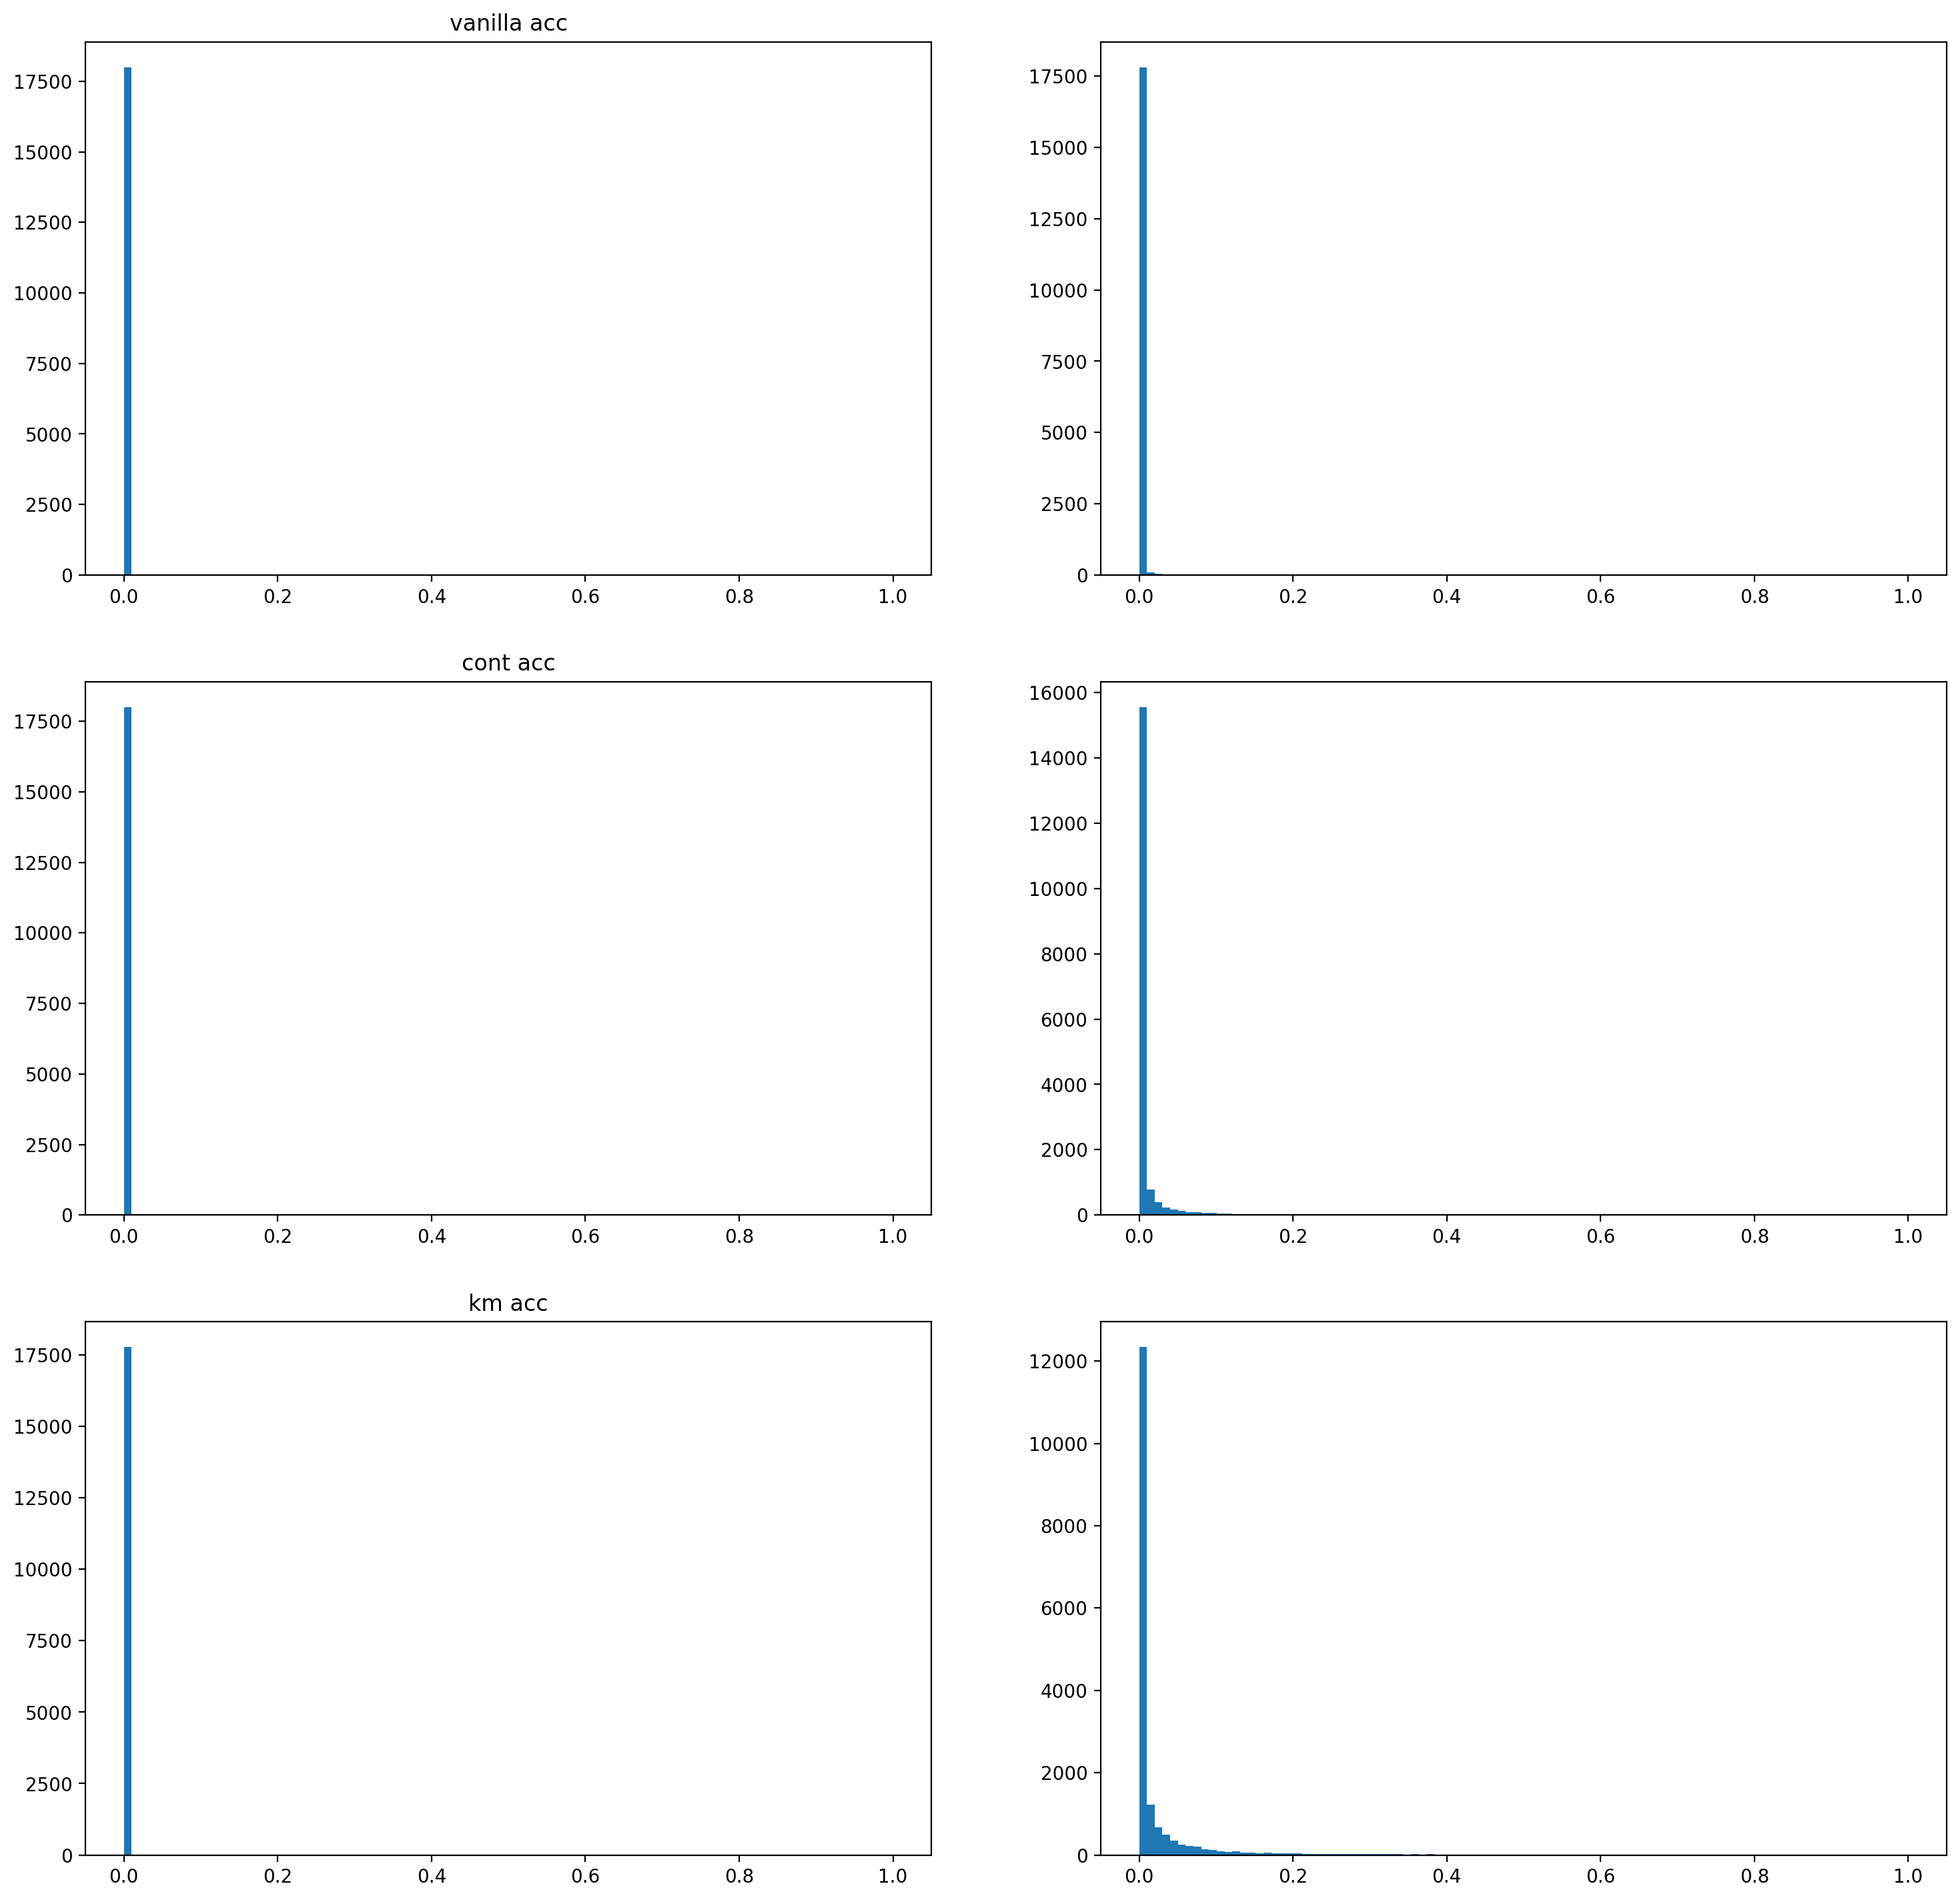

In [50]:
from matplotlib import pyplot as plt
bins = torch.linspace(0., 1, 100)

fig, ax = plt.subplots(3, 2, figsize=(18, 18), dpi=200)
ax[0][0].set_title('vanilla acc')
ax[0][0].hist(vanilla_mg[:, 0].cpu(), bins)
ax[0][1].hist(vanilla_mg[:, 1].cpu(), bins)
ax[1][0].set_title('cont acc')
ax[1][0].hist(continuous_mg[:, 0].cpu(), bins)
ax[1][1].hist(continuous_mg[:, 1].cpu(), bins)
ax[2][0].set_title('km acc')
ax[2][0].hist(km_mg[:, 0].cpu(), bins)
ax[2][1].hist(km_mg[:, 1].cpu(), bins)

In [23]:
cost = cache['PolicyCostKMTaper']
liter = iter(loader)

In [ ]:
batch = next(liter)

In [ ]:
magnitudes = []
examples = []
cost.config.uncertainty_n_pred = 30
cost.config.u_reg = 0
cost.config.lambda_o = 0.0
cost.config.lambda_p = 1.0
cost.config.lambda_l = 0.0

for k in batch:
    if torch.is_tensor(batch[k]):
        batch[k] = batch[k].cuda()
actions = batch['actions'].clone()
actions.requires_grad = True
predictions = fm.unfold(actions[:, :2], batch)
c = cost.calculate_cost(batch, predictions)
c['policy_loss'].backward()

actions.grad.shape
actions.grad[3]

In [231]:
actions

tensor([[[-0.6205,  0.0086],
         [-0.6333,  0.0618],
         [-0.6786,  0.2339],
         [-0.7127,  0.3260],
         [-0.7001,  0.4617],
         [-0.6468,  0.3001],
         [-0.5766,  0.1824],
         [-0.4883, -0.0730],
         [-0.3740, -0.0755],
         [-0.2028, -0.0837],
         [ 0.0395, -0.0530],
         [ 0.4398, -0.0288],
         [ 0.8600, -0.0399],
         [ 0.9905, -0.0089],
         [ 0.8247,  0.0036],
         [ 0.6099,  0.0261],
         [ 0.6631, -0.0244],
         [ 0.9916, -0.1953],
         [ 1.2715, -0.2752],
         [ 1.3814, -0.3856],
         [ 1.3639, -0.2110],
         [ 1.2609, -0.1181],
         [ 1.1024,  0.0461],
         [ 0.9416,  0.0148],
         [ 0.8327,  0.0119],
         [ 0.7885,  0.0204],
         [ 0.6770,  0.0119],
         [ 0.4875,  0.0132],
         [ 0.4071,  0.0118],
         [ 0.4901,  0.0159]],

        [[-0.5295, -0.1304],
         [-0.6543, -0.1403],
         [-0.6875, -0.1301],
         [-0.7161, -0.1398],
         [-0

In [32]:
def plot_images(images):
    images = images.detach().cpu().numpy()
    step = max(images.shape[1] // 10, 1)
    l = images.shape[1] // step
    f, axs = plt.subplots(1, l, dpi=200)
    for i in range(max(l, 1)):
        image = np.transpose(images[0][i * step], (1, 2, 0))
        if l == 1:
            axs.imshow(image)
            axs.set_axis_off()
        else:
            axs[i].imshow(image)
            axs[i].set_axis_off()

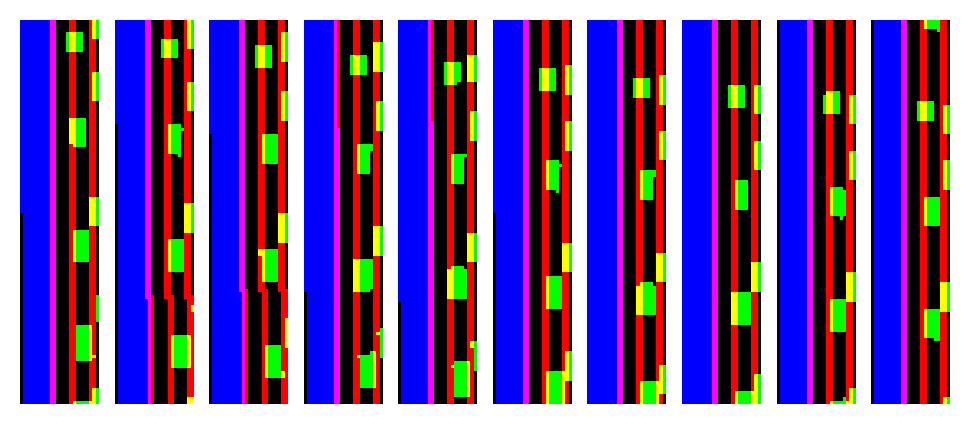

In [33]:
import numpy as np
plot_images(batch['input_images'])

In [329]:
batch['input_images'][3].shape

IndexError: index 3 is out of bounds for dimension 0 with size 1

# Constructing an example

I want to make a fake example and study how gradients change within that example. We're not going to move the car around in the frame.

In [47]:
import numpy as np

In [48]:
cost = CostType(CostType.Config(), fm, data_store.stats)
cost.estimate_uncertainty_stats(loader)
cache[CostType.__name__] = cost

NameError: name 'CostType' is not defined

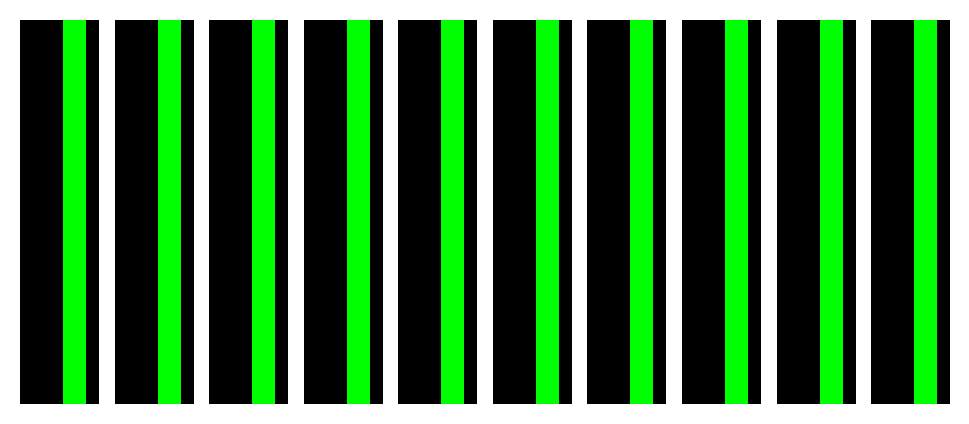

In [49]:
cnd_car_in_front = torch.zeros_like(batch['input_images'])
target_car_in_front = torch.zeros_like(batch['target_images'])

car_slice = slice(13, 20) # to the right
# car_slice = slice(4, 11) # to the left
# car_slice = slice(0, 24)
# car_slice_x = slice(70, 85) # behind
# car_slice_x = slice(20, 35) # in front
car_slice_x = slice(0, 117) # everywhere
cnd_car_in_front[:, :, 1, car_slice_x, car_slice] = 1
target_car_in_front[:, :, 1, car_slice_x, car_slice] = 1
plot_images(cnd_car_in_front)
dummy_images = target_car_in_front[:1, :2]

In [50]:
import torch
from ppuu.data.dataloader import Dataset, DataStore
from torch.utils.data import DataLoader

# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/traffic-data_offroad/state-action-cost/data_i80_v0/"
# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/vlad/traffic-data_offroad_50_test_train_same/state-action-cost/data_i80_v0/"
# ds_path = "/home/us441/nvidia-collab/vlad/traffic-data-5-small/state-action-cost/data_i80_v0/"
ds_path = "/home/us441/nvidia-collab/vlad/traffic-data-5/state-action-cost/data_i80_v0/"

data_store = DataStore(ds_path)

dataset = Dataset(
    data_store, "val", 20, 30, size=1000, normalize=False, shift=False, random_actions=False, state_diffs=True
)

loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=0,
)
liter = iter(loader)

batch = next(liter)

In [51]:
actions = torch.tensor([[1.0, 0.0], [1.0, 0.0]], requires_grad=True, device='cuda')
dummy_stats = {}
for k in data_store.stats:
    if 'std' in k:
        dummy_stats[k] = torch.ones_like(data_store.stats[k])
    else:
        dummy_stats[k] = torch.zeros_like(data_store.stats[k])

In [52]:
print(dummy_stats['s_diff_std'].shape)
print(data_store.stats['s_diff_std'].shape)

torch.Size([5])
torch.Size([5])


In [56]:
import ppuu.modeling.km
import imp 
imp.reload(ppuu.modeling.km)
predict_states_diff = ppuu.modeling.km.predict_states_diff
predict_states = ppuu.modeling.km.predict_states


init_state = torch.tensor([0.0, 0.0, 1.0, 0.0, 10.0]).cuda()
next_state_0 = predict_states(init_state.unsqueeze(0), actions[0].unsqueeze(0), dummy_stats)
next_state_1 = predict_states(next_state_0, actions[1].unsqueeze(0), dummy_stats)

In [57]:
next_state_1.shape
next_states = torch.cat([next_state_0, next_state_1])
print(next_states.shape)

torch.Size([2, 5])


In [64]:
masks_0 = cost.get_masks(dummy_images.cuda(),
                         next_states, 
                         actions,
                         batch['car_sizes'], 
                         unnormalize=False,
                         )

IndexError: too many indices for tensor of dimension 2

In [63]:
print(batch['car_sizes'].shape)
print(dummy_images.shape)

torch.Size([1, 2])
torch.Size([1, 2, 3, 117, 24])


In [408]:
masks_0.sum()

tensor(208.2235, device='cuda:0', grad_fn=<SumBackward0>)

In [409]:
target_car_in_front[:1].shape

torch.Size([1, 30, 3, 117, 24])

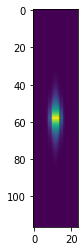

In [410]:
plt.imshow(masks_0[0][0].detach().cpu())

In [411]:
c = dummy_images[:, :, 1].cuda() * masks_0

In [416]:
c = c.view(*c.shape[:2], -1).sum()
c.backward()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [ ]:
print(actions.grad)

## dummy_images.shape

In [ ]:
masks_0.shape

# 1D case

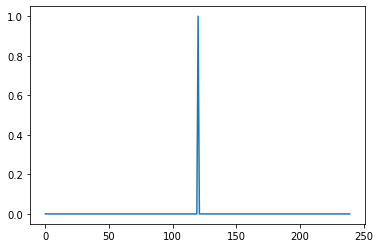

In [320]:
N = 240
img = torch.zeros(N)
img[int(N*0.5)] = 1
plt.plot(img)

In [233]:
coords = torch.linspace(-10, 10, N)
shift = torch.tensor(-4.0, requires_grad=True)
coords_s = coords - shift
mask = (5 - coords_s.abs()).clamp(min=0)

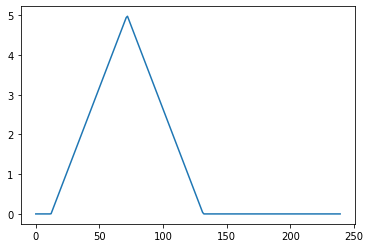

In [234]:
plt.plot(mask.detach())

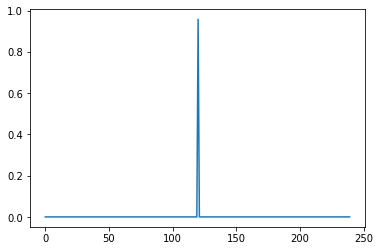

In [235]:
c = (mask * img)
plt.plot(c.detach())

In [236]:
img.sum()

tensor(1.)

In [237]:
c.sum().backward()

In [238]:
shift.grad

tensor(1.)

In [1]:
import torch

In [8]:
a = torch.tensor([2.0, 2.0])

In [9]:
a.norm()

tensor(2.8284)